# Test assignment of Volodymyr Holomb
Important notes:
1. main folder with input and output data is on [github](https://github.com/woldemarg/lightit_test)
2. original script is [here](https://github.com/woldemarg/lightit_test/blob/master/sripts/main.R)
3. this notebook contains some minor inline comments, extended description is [here](https://github.com/woldemarg/lightit_test/blob/master/README.md) 

In [1]:
# install.packages(c(
#     "tidyverse",
#     "lubridate",
#     "geosphere",
#     "randomForest",
#     "glmnet",
#     "fastDummies",
#     "gbm",
#     "xgboost")
# )

In [2]:
library(tidyverse)
library(lubridate)    #parse dates
library(geosphere)    #calculate distance to event location
library(randomForest)
library(glmnet)
library(fastDummies)  #one-hot-encoding for ridge and xgb
library(gbm)
library(xgboost)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.2"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'geosphere' was built under R version 3.6.3"Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to se

## Data downloading and cleaning

In [3]:
#all files were previously encoded to utf-8
description <- read.csv("data/encoded/columns_description.csv", encoding = "utf-8", stringsAsFactors = FALSE)
events <- read.csv("data/encoded/events_Hokkaido.csv", encoding = "utf-8", stringsAsFactors = FALSE)
holidays <- read.csv("data/encoded/holidays_Japan.csv", encoding = "utf-8", stringsAsFactors = FALSE)
jalan <- read.csv("data/encoded/jalan_shinchitose.csv", encoding = "utf-8", stringsAsFactors = FALSE)
rakuten <- read.csv("data/encoded/rakuten_shinchitose.csv", encoding = "utf-8", stringsAsFactors = FALSE)
weather <- read.csv("data/encoded/weather_Hokkaido.csv", encoding = "utf-8", stringsAsFactors = FALSE)

names(rakuten) <- description$`Row.EN.`[1:48]
names(jalan) <- description$`Row.EN.`[49:94]

In [4]:
#parsing dates in all input data
get_date <- function(timestamp, format = "Y/m/d H:M") {
  return(date(parse_date_time(timestamp, format)))
}

holidays <- holidays %>%
  mutate(day = get_date(day, "Y/m/d"))

events <- events %>%
  mutate(
    start_date = get_date(start_date, "Y/m/d"),
    end_date = get_date(end_date, "Y/m/d"),
  )

weather <- weather %>%
  mutate(date = get_date(date, "Y/m/d"))

In [5]:
#detecting "identical" columns within main datasets
jalan_filtered <- jalan %>%
  mutate(
    company_name = "jalan",
    request_date = get_date(request_date_time),
    pickup_date = get_date(pickup_date_time),
    return_date = get_date(return_date_time),
    cancellation_date = get_date(cancellation_date_time),
    is_cancelled = ifelse(!is.na(cancellation_date), 1, 0)
    #num_of_passengers = as.numeric(str_extract_all(number_of_passengers, "\\d+")[[1]][1]),
    #num_of_children = as.numeric(str_extract_all(number_of_passengers, "\\d+")[[1]][2])
  ) %>%
  select(
    company_name,
    request_date,
    pickup_date,
    return_date,
    request_date,
    cancellation_date,
    is_cancelled
    #num_of_passengers,
    #num_of_children,
    #arrival_flight,
    #total_price
)

In [6]:
rakuten_filtered <- rakuten %>%
  mutate(
    company_name = "rakuten",
    request_date = get_date(request_date_time),
    pickup_date = get_date(pickup_date_time),
    return_date = get_date(return_date_time),
    cancellation_date = get_date(cancel_request_date_time),
    is_cancelled = ifelse(!is.na(cancellation_date), 1, 0),
  ) %>%
  # rename(
  #   car_class = company_car_class_code,
  #   num_of_passengers = number_of_passengers,
  #   num_of_children = number_of_children,
  #   arrival_flight = flight_number,
  #   total_price = taxable_amount
  # ) %>%
  select(
    company_name,
    request_date,
    pickup_date,
    return_date,
    request_date,
    cancellation_date,
    is_cancelled,
    #num_of_passengers, #leave these and above columns for further predicting improvement, 
    #num_of_children,   #as they may be useful for some feature engineering,  
    #arrival_flight,    #such as assesing promotional offers of each company etc.
    #total_price        
  )


df_joined <- bind_rows(jalan_filtered, rakuten_filtered)
#df_joined$arrival_flight[df_joined$arrival_flight == "0"] <- NA

#write_csv(df_joined, "derived/df_joined.csv")
head(df_joined, 5)

company_name,request_date,pickup_date,return_date,cancellation_date,is_cancelled
jalan,2016-02-17,2016-03-20,2016-03-22,NA,0
jalan,2016-02-23,2016-03-05,2016-03-07,NA,0
jalan,2016-02-25,2016-03-19,2016-03-22,NA,0
jalan,2016-02-27,2016-03-18,2016-03-20,NA,0
jalan,2016-03-01,2016-03-03,2016-03-05,2016-03-03,1


In [7]:
#preparing data in such a way to get a row with
#target value for each company per each given date
model_data <- df_joined %>%
  filter(is_cancelled == 0) %>%
  group_by(pickup_date, company_name) %>%
  summarise(target = n()) %>%
  ungroup() %>%
  spread(key = "pickup_date", value = "target") %>% 
  gather(key = "pickup_date", value = "target", -company_name) %>%
  select(target, everything())

model_data[is.na(model_data)] <- 0
model_data$pickup_date <- as_date(model_data$pickup_date)
model_data$company_name <- as_factor(model_data$company_name)

head(model_data, 5)

target,company_name,pickup_date
0,jalan,2016-02-21
2,rakuten,2016-02-21
0,jalan,2016-02-27
2,rakuten,2016-02-27
0,jalan,2016-02-28


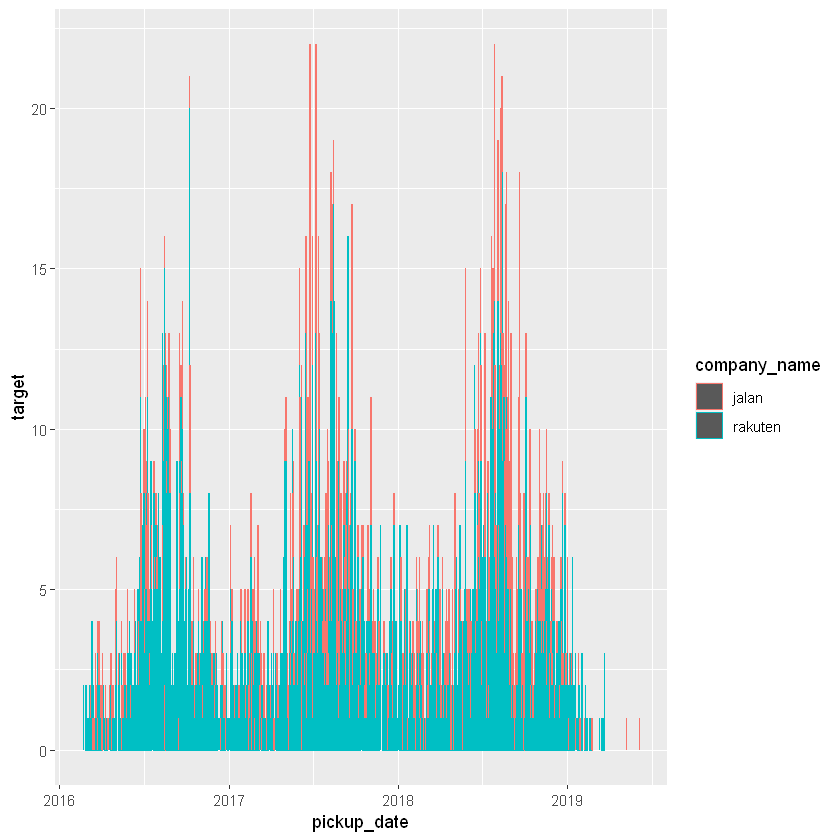

In [8]:
#as it was expected, rental statistics shows a severe seasonality,
#so it is cruscial to preserve this characteristic for modelling
ggplot(data = model_data, aes(x = pickup_date, y = target, color = company_name)) +
  geom_bar(stat = "identity")

## Simple mean approach
We will try to predict target values via simple mean of day-of-week and month pair for each company

In [9]:
#simple average approach
get_cv_rmse_mean_model <- function(data,
                                   k = 10,
                                   seed = 1) {
  set.seed(seed)
  
  data <- data %>%
    mutate(dow = as.character(wday(pickup_date, label = TRUE)),
           mon = month(pickup_date)) %>%
    select(-pickup_date)
  
  data <- data[sample(nrow(data)),]
  folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
  rmse <- c()
  
  for (i in 1:k) {
    indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[indices,]
    train_data <- data[-indices,]
    
    mean_model <- train_data %>%
      group_by(company_name, dow, mon) %>%
      summarize(predicts = mean(target)) %>%
      ungroup()
    
    test_data <- left_join(test_data, mean_model,
                           by = c("company_name", "dow", "mon"))
    
    rmse[i] <- sqrt(mean((
      test_data$predicts - test_data$target
    ) ^ 2))
  }
  
  mean(rmse)
}

In [10]:
rmse_mean_model <- get_cv_rmse_mean_model(model_data)

rmse_mean_model

[1] 2.147598

## Feature engineering

In [11]:
#we are going to represent seasonality pattern in data through target encoding month-and-day-of-week feature 
model_data <- model_data %>%
  mutate(mon_dow = paste(month(pickup_date, label = TRUE),
                         as.character(wday(pickup_date, label = TRUE)),
                         sep = "_"))

mon_dow_lookup <- model_data %>%
  group_by(mon_dow) %>%
  summarise(mon_dow_encoded = mean(target))

#target encoding
model_data <-
  left_join(model_data, mon_dow_lookup, by = "mon_dow") %>%
  select(-mon_dow)

head(model_data, 5)

target,company_name,pickup_date,mon_dow_encoded
0,jalan,2016-02-21,1.000000
2,rakuten,2016-02-21,1.000000
0,jalan,2016-02-27,1.666667
2,rakuten,2016-02-27,1.666667
0,jalan,2016-02-28,1.000000


In [12]:
#start of long weekend (first day of two or more holidays in a row)
holidays <- holidays %>%
  mutate(start_long_we = ifelse(
    (lag(Japan) == 0 & Japan == 1 & lead(Japan) == 1) |
      wday(day) == 6 & Japan == 1 |
      wday(day) == 7 & lead(Japan, 2) == 1,
    1,
    0
  ))


model_data <- model_data %>%
  mutate(is_start_long_we = holidays$start_long_we[match(pickup_date, holidays$day)])

head(model_data, 5)

target,company_name,pickup_date,mon_dow_encoded,is_start_long_we
0,jalan,2016-02-21,1.000000,0
2,rakuten,2016-02-21,1.000000,0
0,jalan,2016-02-27,1.666667,0
2,rakuten,2016-02-27,1.666667,0
0,jalan,2016-02-28,1.000000,0


## Modelling on base data (dates, holidays, events that are available for predicting)

In [13]:
#upcoming events
avg_rent_duration <-
  as.numeric(mean(df_joined$return_date[df_joined$is_cancelled != 0] - df_joined$pickup_date[df_joined$is_cancelled != 0]))

get_events <- function(pickup_day) {
  evs <- events %>%
    filter(city_id != 1536 &
             start_date == pickup_day + 1 &            #events, that start on the next day from pickup date
             end_date - start_date < avg_rent_duration)
  
  evs$dist <-
    apply(evs, 1, function(row)
      distm(as.numeric(row[6:7]), c(141.650876, 42.8209577), fun = distHaversine) /
        1000)
  
  nrow(subset(evs, dist > 60)) #manual adjustment
}

model_data$events <- sapply(model_data$pickup_date, get_events)

#write_csv(model_data, "derived/model_data.csv")

head(model_data, 5)

target,company_name,pickup_date,mon_dow_encoded,is_start_long_we,events
0,jalan,2016-02-21,1.000000,0,0
2,rakuten,2016-02-21,1.000000,0,0
0,jalan,2016-02-27,1.666667,0,0
2,rakuten,2016-02-27,1.666667,0,0
0,jalan,2016-02-28,1.000000,0,0


In [14]:
#modelling
get_cv_rmse_rf_model <- function(data,
                                 k = 10,
                                 seed = 1) {
  set.seed(seed)
  
  data <- data %>%
    select(-pickup_date)
  
  data <- data[sample(nrow(data)),]
  folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
  rmse <- c()
  
  for (i in 1:k) {
    indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[indices,]
    train_data <- data[-indices,]
    
    rf_mod = randomForest(target ~ . , data = train_data)
    predicts <- predict(rf_mod, test_data[, -1])
    
    rmse[i] <- sqrt(mean((predicts - test_data$target) ^ 2))
  }
  mean(rmse)
}

In [15]:
get_cv_rmse_ridge_model <- function(data,
                                    k = 10,
                                    seed = 1) {
  set.seed(seed)
  
  data <- data %>%
    select(-pickup_date) %>%
    dummy_cols(
      select_columns = c("company_name"),
      remove_first_dummy = TRUE,
      remove_selected_columns = TRUE
    )
  
  data <- data[sample(nrow(data)),]
  folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
  rmse <- c()
  
  for (i in 1:k) {
    indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[indices,]
    train_data <- data[-indices,]
    
    cv_ridge <- cv.glmnet(
      x = as.matrix(train_data[names(train_data) != "target"]),
      y = train_data[["target"]],
      nfolds = 10,
      standardize = TRUE,
      alpha = 0
    )
    
    predicts <-
      predict(cv_ridge,
              s = cv_ridge$lambda.min,
              newx = as.matrix(test_data[, -1]))
    
    rmse[i] <- sqrt(mean((predicts - test_data$target) ^ 2))
  }
  mean(rmse)
}

In [16]:
rmse_rf_model <- get_cv_rmse_rf_model(model_data)

rmse_rf_model

[1] 2.101024

In [17]:
rmse_ridge_model <- get_cv_rmse_ridge_model(model_data)

rmse_ridge_model

[1] 2.044695

## Some more feature engineering for weather data

In [18]:
#trying to deal with weather forcast
city_weather <- weather %>% filter(city_id == 1536) %>%
  distinct(date, .keep_all = TRUE) %>%
  mutate(avg_temp = (low_temp + high_temp) / 2) %>%
  select(date, avg_temp) %>%
  complete(date = seq(date[1], as_date("2019-02-28"), by = "1 day")) %>%
  fill(avg_temp)

rented_cars <- df_joined %>%
  filter(is_cancelled == 0) %>%
  mutate(mon = month(pickup_date)) %>%
  group_by(mon) %>%
  summarise(rented = n()) %>%
  ungroup()

cancelled_orders <- df_joined %>%
  filter(is_cancelled == 1 &
           pickup_date - cancellation_date <= 1) %>%
  mutate(mon = month(pickup_date)) %>%
  group_by(mon) %>%
  summarise(cancelled = n()) %>%
  ungroup()

rush_cancellations <- rented_cars %>%
  left_join(cancelled_orders, by = "mon") %>%
  mutate(rush_ratio = cancelled / (rented + cancelled)) %>%
  select(mon, rush_ratio)

temp_drop_days <-
  tibble(drop = ifelse(diff(city_weather$avg_temp, 2) / na.omit(lag(
    city_weather$avg_temp, 2
  )) < 0, 1, 0),
  date = city_weather$date[3:nrow(city_weather)])

model_data_alt <- model_data %>%
  inner_join(temp_drop_days, by = c("pickup_date" = "date")) %>%
  mutate(drop = ifelse(drop == 1,
                       rush_cancellations$rush_ratio[match(month(pickup_date), rush_cancellations$mon)],
                       0))

#write_csv(model_data_alt, "derived/model_data_alt.csv")

head(model_data_alt)

target,company_name,pickup_date,mon_dow_encoded,is_start_long_we,events,drop
2,jalan,2017-07-11,2.538462,0,1,0.0000000
2,rakuten,2017-07-11,2.538462,0,1,0.0000000
4,jalan,2017-07-12,3.045455,0,2,0.0280236
3,rakuten,2017-07-12,3.045455,0,2,0.0280236
10,jalan,2017-07-13,3.625000,0,2,0.0000000
6,rakuten,2017-07-13,3.625000,0,2,0.0000000


## Modelling on extended data (same as above plus weather forecast)

In [19]:
rmse_rf_model_alt_data <- get_cv_rmse_rf_model(model_data_alt)

rmse_rf_model_alt_data

[1] 2.163531

In [20]:
rmse_ridge_model_alt_data <- get_cv_rmse_ridge_model(model_data_alt)

rmse_ridge_model_alt_data

[1] 2.080732

## Gradient boosting machines

In [21]:
#gbm tuning via hyperparameter grid
hyper_grid <- expand.grid(
  shrinkage = c(.1, .3, .5),
  interaction.depth = c(3, 5, 7),
  n.minobsinnode = c(5, 10, 15),
  bag.fraction = c(.5, .6, .8),
  optimal_trees = 0,
  min_RMSE = 0
)

#grid search
for (i in 1:nrow(hyper_grid)) {
  set.seed(1)
  
  gbm_tune <- gbm(
    formula = target ~ .,
    distribution = "gaussian",
    data = model_data %>% select(-pickup_date),
    n.trees = 1000,
    interaction.depth = hyper_grid$interaction.depth[i],
    shrinkage = hyper_grid$shrinkage[i],
    n.minobsinnode = hyper_grid$n.minobsinnode[i],
    bag.fraction = hyper_grid$bag.fraction[i],
    train.fraction = .75,
    n.cores = NULL,
    verbose = FALSE
  )
  
  hyper_grid$optimal_trees[i] <- which.min(gbm_tune$valid.error)
  hyper_grid$min_RMSE[i] <- sqrt(min(gbm_tune$valid.error))
}

hyper_grid %>%
  arrange(min_RMSE) %>%
  head(10)

shrinkage,interaction.depth,n.minobsinnode,bag.fraction,optimal_trees,min_RMSE
0.3,3,10,0.6,9,2.350979
0.3,3,15,0.6,9,2.350979
0.3,3,5,0.5,17,2.353812
0.3,3,5,0.6,12,2.355135
0.3,3,10,0.8,17,2.355691
0.5,3,5,0.6,9,2.360192
0.5,3,15,0.6,9,2.360804
0.3,5,5,0.6,9,2.361544
0.3,5,15,0.8,14,2.361583
0.3,5,10,0.6,9,2.363020


In [22]:
get_cv_rmse_gbm_model <- function(data,
                                  k = 10,
                                  seed = 1) {
  set.seed(seed)
  
  data <- data %>%
    select(-pickup_date)
  
  data <- data[sample(nrow(data)),]
  folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
  rmse <- c()
  
  for (i in 1:k) {
    indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[indices,]
    train_data <- data[-indices,]
    
    gbm_best <- gbm(
      formula = target ~ .,
      distribution = "gaussian",
      data = train_data,
      n.trees = 10,
      interaction.depth = 3,
      shrinkage = .3,
      n.minobsinnode = 10,
      bag.fraction = .6,
      train.fraction = .75,
      n.cores = NULL,
      verbose = FALSE
    )
    
    predicts <- predict(gbm_best, test_data[, -1])
    
    rmse[i] <- sqrt(mean((predicts - test_data$target) ^ 2))
  }
  mean(rmse)
}

In [23]:
rmse_gbm_model <- get_cv_rmse_gbm_model(model_data)

rmse_gbm_model

Using 10 trees...
Using 10 trees...
Using 10 trees...
Using 9 trees...
Using 9 trees...
Using 9 trees...
Using 10 trees...
Using 8 trees...
Using 7 trees...
Using 4 trees...


[1] 2.060712

In [24]:
rmse_gbm_model_alt_data <- get_cv_rmse_gbm_model(model_data_alt)

rmse_gbm_model_alt_data

Using 8 trees...
Using 10 trees...
Using 7 trees...
Using 10 trees...
Using 10 trees...
Using 10 trees...
Using 10 trees...
Using 10 trees...
Using 10 trees...
Using 6 trees...


[1] 2.095893

## XGBoost

In [25]:
#hyperparameter grid for xgboost
hyper_grid_xgb <- expand.grid(
  eta = c(.1, .3),
  max_depth = c(3, 5),
  min_child_weight = c(5, 7),
  subsample = c(.6, .8),
  colsample_bytree = c(.8, 1),
  optimal_trees = 0,
  min_RMSE = 0
)

xgb_data <- model_data %>%
  select(-pickup_date) %>%
  dummy_cols(
    select_columns = c("company_name"),
    remove_first_dummy = TRUE,
    remove_selected_columns = TRUE
  )

#grid search
for (i in 1:nrow(hyper_grid_xgb)) {
  #create parameter list
  params <- list(
    eta = hyper_grid_xgb$eta[i],
    max_depth = hyper_grid_xgb$max_depth[i],
    min_child_weight = hyper_grid_xgb$min_child_weight[i],
    subsample = hyper_grid_xgb$subsample[i],
    colsample_bytree = hyper_grid_xgb$colsample_bytree[i]
  )
  
  set.seed(1)
  
  #train model
  xgb_tune <- xgb.cv(
    params = params,
    data = as.matrix(xgb_data[names(xgb_data) != "target"]),
    label = xgb_data[["target"]],
    nrounds = 100,
    nfold = 5,
    objective = "reg:linear",
    verbose = 0,
    early_stopping_rounds = 10 #stop if no improvement for 10 consecutive trees
  )
  
  hyper_grid_xgb$optimal_trees[i] <-
    which.min(xgb_tune$evaluation_log$test_rmse_mean)
  hyper_grid_xgb$min_RMSE[i] <-
    min(xgb_tune$evaluation_log$test_rmse_mean)
}

hyper_grid_xgb %>%
  arrange(min_RMSE) %>%
  head(10)

eta,max_depth,min_child_weight,subsample,colsample_bytree,optimal_trees,min_RMSE
0.3,3,7,0.8,1.0,13,2.021410
0.3,3,5,0.8,1.0,16,2.023387
0.3,3,5,0.6,1.0,14,2.030863
0.1,3,5,0.6,1.0,25,2.032185
0.1,3,7,0.6,1.0,26,2.032598
0.1,3,5,0.8,1.0,34,2.033243
0.1,3,5,0.6,0.8,34,2.033837
0.1,3,7,0.8,1.0,30,2.033870
0.1,3,7,0.6,0.8,34,2.033904
0.3,3,7,0.6,1.0,12,2.035511


In [26]:
get_cv_rmse_xgb_model <- function(data,
                                  k = 10,
                                  seed = 1) {
  set.seed(seed)
  
  data <- data %>%
    select(-pickup_date) %>%
    dummy_cols(
      select_columns = c("company_name"),
      remove_first_dummy = TRUE,
      remove_selected_columns = TRUE
    )
  
  data <- data[sample(nrow(data)),]
  folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
  
  params_final <- list(
    eta = 0.3,
    max_depth = 3,
    min_child_weight = 7,
    subsample = 0.8,
    colsample_bytree = 1
  )
  
  rmse <- c()
  
  for (i in 1:k) {
    indices <- which(folds == i, arr.ind = TRUE)
    test_data <- data[indices,]
    train_data <- data[-indices,]
    
    xgb_mod <- xgboost(
      params = params_final,
      data = as.matrix(train_data[names(train_data) != "target"]),
      label = train_data[["target"]],
      nrounds = 15,
      objective = "reg:linear",
      verbose = 0
    )
    
    predicts <-
      predict(xgb_mod,
              as.matrix(test_data[, -1]))
    
    rmse[i] <- sqrt(mean((predicts - test_data$target) ^ 2))
  }
  mean(rmse)
}

In [27]:
rmse_xgb_model <- get_cv_rmse_xgb_model(model_data)

rmse_xgb_model

[1] 2.045476

In [28]:
rmse_xgb_model_alt_data <- get_cv_rmse_xgb_model(model_data_alt)

rmse_xgb_model_alt_data

[1] 2.103971

## Training XGB and alternative models on full train data 

In [29]:
#parameter list
params_final <- list(
    eta = 0.3,
    max_depth = 3,
    min_child_weight = 7,
    subsample = 0.8,
    colsample_bytree = 1
  )

#train final model for xgb
xgb_fit_final <- xgboost(
  params = params_final,
  data = as.matrix(xgb_data[names(xgb_data) != "target"]),
  label = xgb_data[["target"]],
  nrounds = 15,
  objective = "reg:linear",
  verbose = 0
)


#train final model for ridge on model_data_alt

#despite of fact that model_data_alt (with weather feature) set shows somewhat worse performance
#in terms of picked comparable metrics (i.e. RMSE), I decided to give it a try, especially with
#regard to given below feture importance plots 
ridge_data_alt <- model_data_alt %>%
  select(-pickup_date) %>%
  dummy_cols(
    select_columns = c("company_name"),
    remove_first_dummy = TRUE,
    remove_selected_columns = TRUE
  )

ridge_fit_final_alt <- cv.glmnet(
  x = as.matrix(ridge_data_alt[names(ridge_data_alt) != "target"]),
  y = ridge_data_alt[["target"]],
  nfolds = 10,
  standardize = TRUE,
  alpha = 0
)

#saveRDS(params_final, "results/models/xgb_param.rds")
#saveRDS(xgb_fit_final, "results/models/xgb_model.rds")
#saveRDS(ridge_fit_final_alt, "results/models/ridge_model_alt.rds")

## Feature importance for models on base and extended data sets

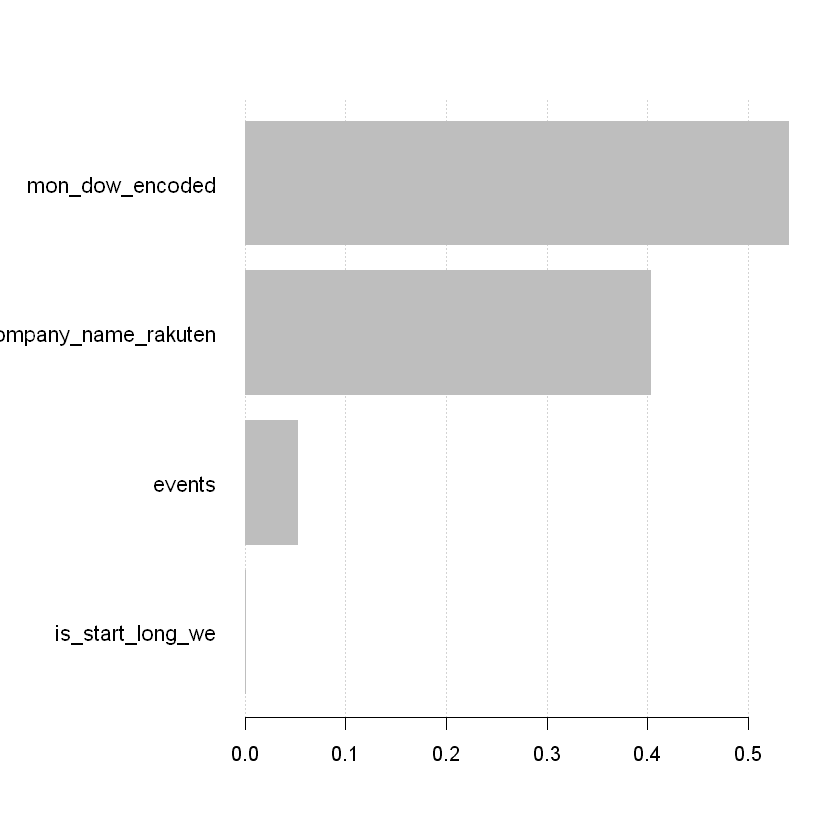

In [30]:
#features importance
importance_matrix <- xgb.importance(model = xgb_fit_final)
xgb.plot.importance(importance_matrix, measure = "Gain")

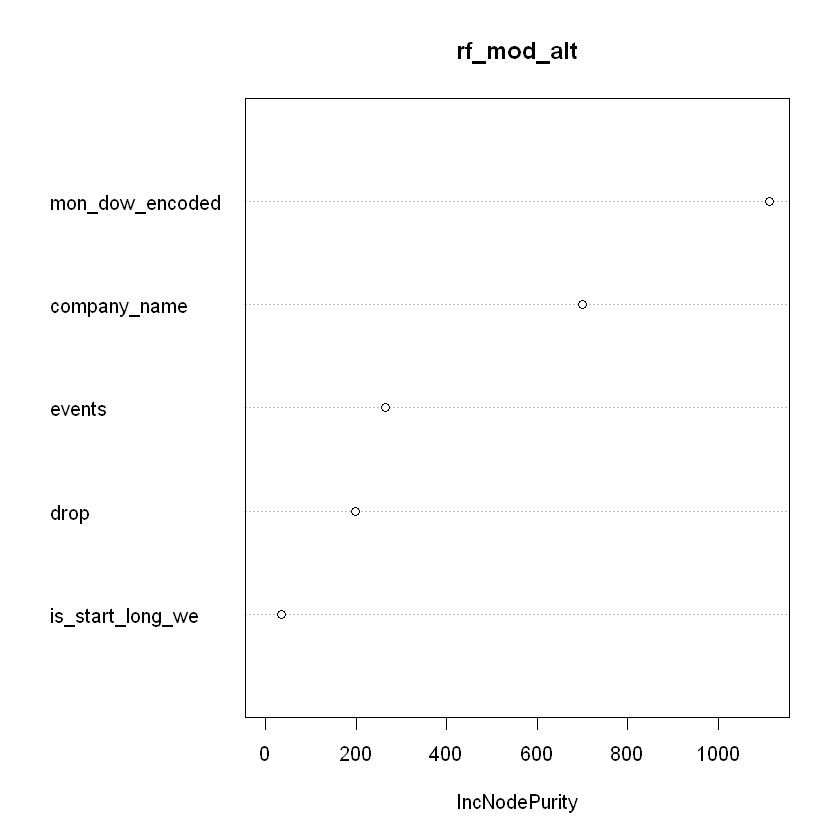

In [31]:
rf_mod_alt <-
  randomForest(target ~ . , data = model_data_alt %>% select(-pickup_date))

varImpPlot(rf_mod_alt)

## Create new data set for task assignment

In [33]:
#new data for Jan-Feb 2019
new_data <- tibble(date = rep(seq(
  as_date("2019-01-01"), as_date("2019-02-28"), by = "1 day"
), each = 2),
company_name = rep(c("rakuten", "jalan"), length(date) / 2)) %>%
  mutate(
    mon_dow = paste(month(date, label = TRUE),
                    as.character(wday(date, label = TRUE)),
                    sep = "_"),
    mon_dow_encoded = mon_dow_lookup$mon_dow_encoded[match(mon_dow, mon_dow_lookup$mon_dow)],
    is_start_long_we = holidays$start_long_we[match(date, holidays$day)],
    events = sapply(date, get_events),
    is_drop_temp = temp_drop_days$drop[match(date, temp_drop_days$date)],
    drop = ifelse(is_drop_temp == 1,
                  rush_cancellations$rush_ratio[match(month(date), rush_cancellations$mon)],
                  0)
  ) %>%
  dummy_cols(
    select_columns = c("company_name"),
    remove_first_dummy = TRUE,
    remove_selected_columns = TRUE
  ) %>%
  select(-mon_dow,-is_drop_temp)

## Final prediction and results for both models and data sets (base vs extended)

In [34]:
#make final predictions
xgb_new_data_preds <-
  predict(xgb_fit_final,
          as.matrix(new_data[,-c(1, 5)]))

ridge_new_data_preds_alt <-
  c(predict(
    ridge_fit_final_alt,
    s = ridge_fit_final_alt$lambda.min,
    newx = as.matrix(new_data[,-1])
  ))

In [38]:
#saving results
results <-
  cbind(new_data[, c(1, 6)], xgb_new_data_preds, ridge_new_data_preds_alt)  %>%
  mutate(
    xgb_rounded = round(xgb_new_data_preds, 0),
    ridge_rounded = round(ridge_new_data_preds_alt, 0)
  )

results_jalan <- subset(results, company_name_rakuten == 0)
results_rakuten <- subset(results, company_name_rakuten == 1)


#write_csv(results_rakuten[, c(1, 3)], "results/predictions/rakuten_xgb_raw.csv")
#write_csv(results_rakuten[, c(1, 5)], "results/predictions/rakuten_xgb_rounded.csv")
#write_csv(results_rakuten[, c(1, 4)], "results/predictions/rakuten_alt_raw.csv")
#write_csv(results_rakuten[, c(1, 6)], "results/predictions/rakuten_alt_rounded.csv")

#write_csv(results_jalan[, c(1, 3)], "results/predictions/jalan_xgb_raw.csv")
#write_csv(results_jalan[, c(1, 5)], "results/predictions/jalan_xgb_rounded.csv")
#write_csv(results_jalan[, c(1, 4)], "results/predictions/jalan_alt_raw.csv")
#write_csv(results_jalan[, c(1, 6)], "results/predictions/jalan_alt_rounded.csv")

In [39]:
head(results)

date,company_name_rakuten,xgb_new_data_preds,ridge_new_data_preds_alt,xgb_rounded,ridge_rounded
2019-01-01,1,1.7225789,2.2538005,2,2
2019-01-01,0,0.5776951,0.4899393,1,0
2019-01-02,1,1.9008294,2.3476396,2,2
2019-01-02,0,0.6498736,0.5837784,1,1
2019-01-03,1,1.7225789,2.1847061,2,2
2019-01-03,0,0.5776951,0.4208449,1,0
